# (a) Data Pre-processing:
#### Create a binary label based on the column “Chance of Admit”. Convert any values bigger than the median to 1 and 0 otherwise. Split the data into training and validation sets. You can use a 80-20 split.

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

test = pd.read_csv('data_test-2.csv', index_col=0)
data_train = pd.read_csv('data_train-2.csv', index_col=0)

# drop rows with missing data (I believe there are none)
test.dropna(inplace=True)
data_train.dropna(inplace=True)

# cast to float64 to stop getting warnings (in normalization)
data_train = data_train.astype('float64')
test = test.astype('float64')

# separate features and labels
test.drop(columns=['Serial No.'], inplace=True)
X = data_train.loc[:,data_train.columns.difference(['Chance of Admit ','Serial No.'])]
y = data_train.loc[:,['Chance of Admit ']]
test.reindex(columns=X.columns)

# set labels to 0/1
med = y.median()
y[y<=med] = 0; y[y>med] = 1
y = pd.Series(y['Chance of Admit '])

# normalize data: (x-u)/σ
for col in X:
    if col=='Research':continue
    for index, row in X.iterrows():
        X.at[index,col] = ((row[col])-X[col].mean()) / X[col].std()
for col in test:
    if col=='Research':continue
    for index, row in test.iterrows():
        test.at[index,col] = ((row[col])-test[col].mean()) / test[col].std()

# train/validate split
X, Xv, y, yv = train_test_split(X,y, test_size=0.2, random_state=13)
X.reset_index(drop=True, inplace=True)
Xv.reset_index(drop=True, inplace=True)
y.reset_index(drop=True, inplace=True)
yv.reset_index(drop=True, inplace=True)


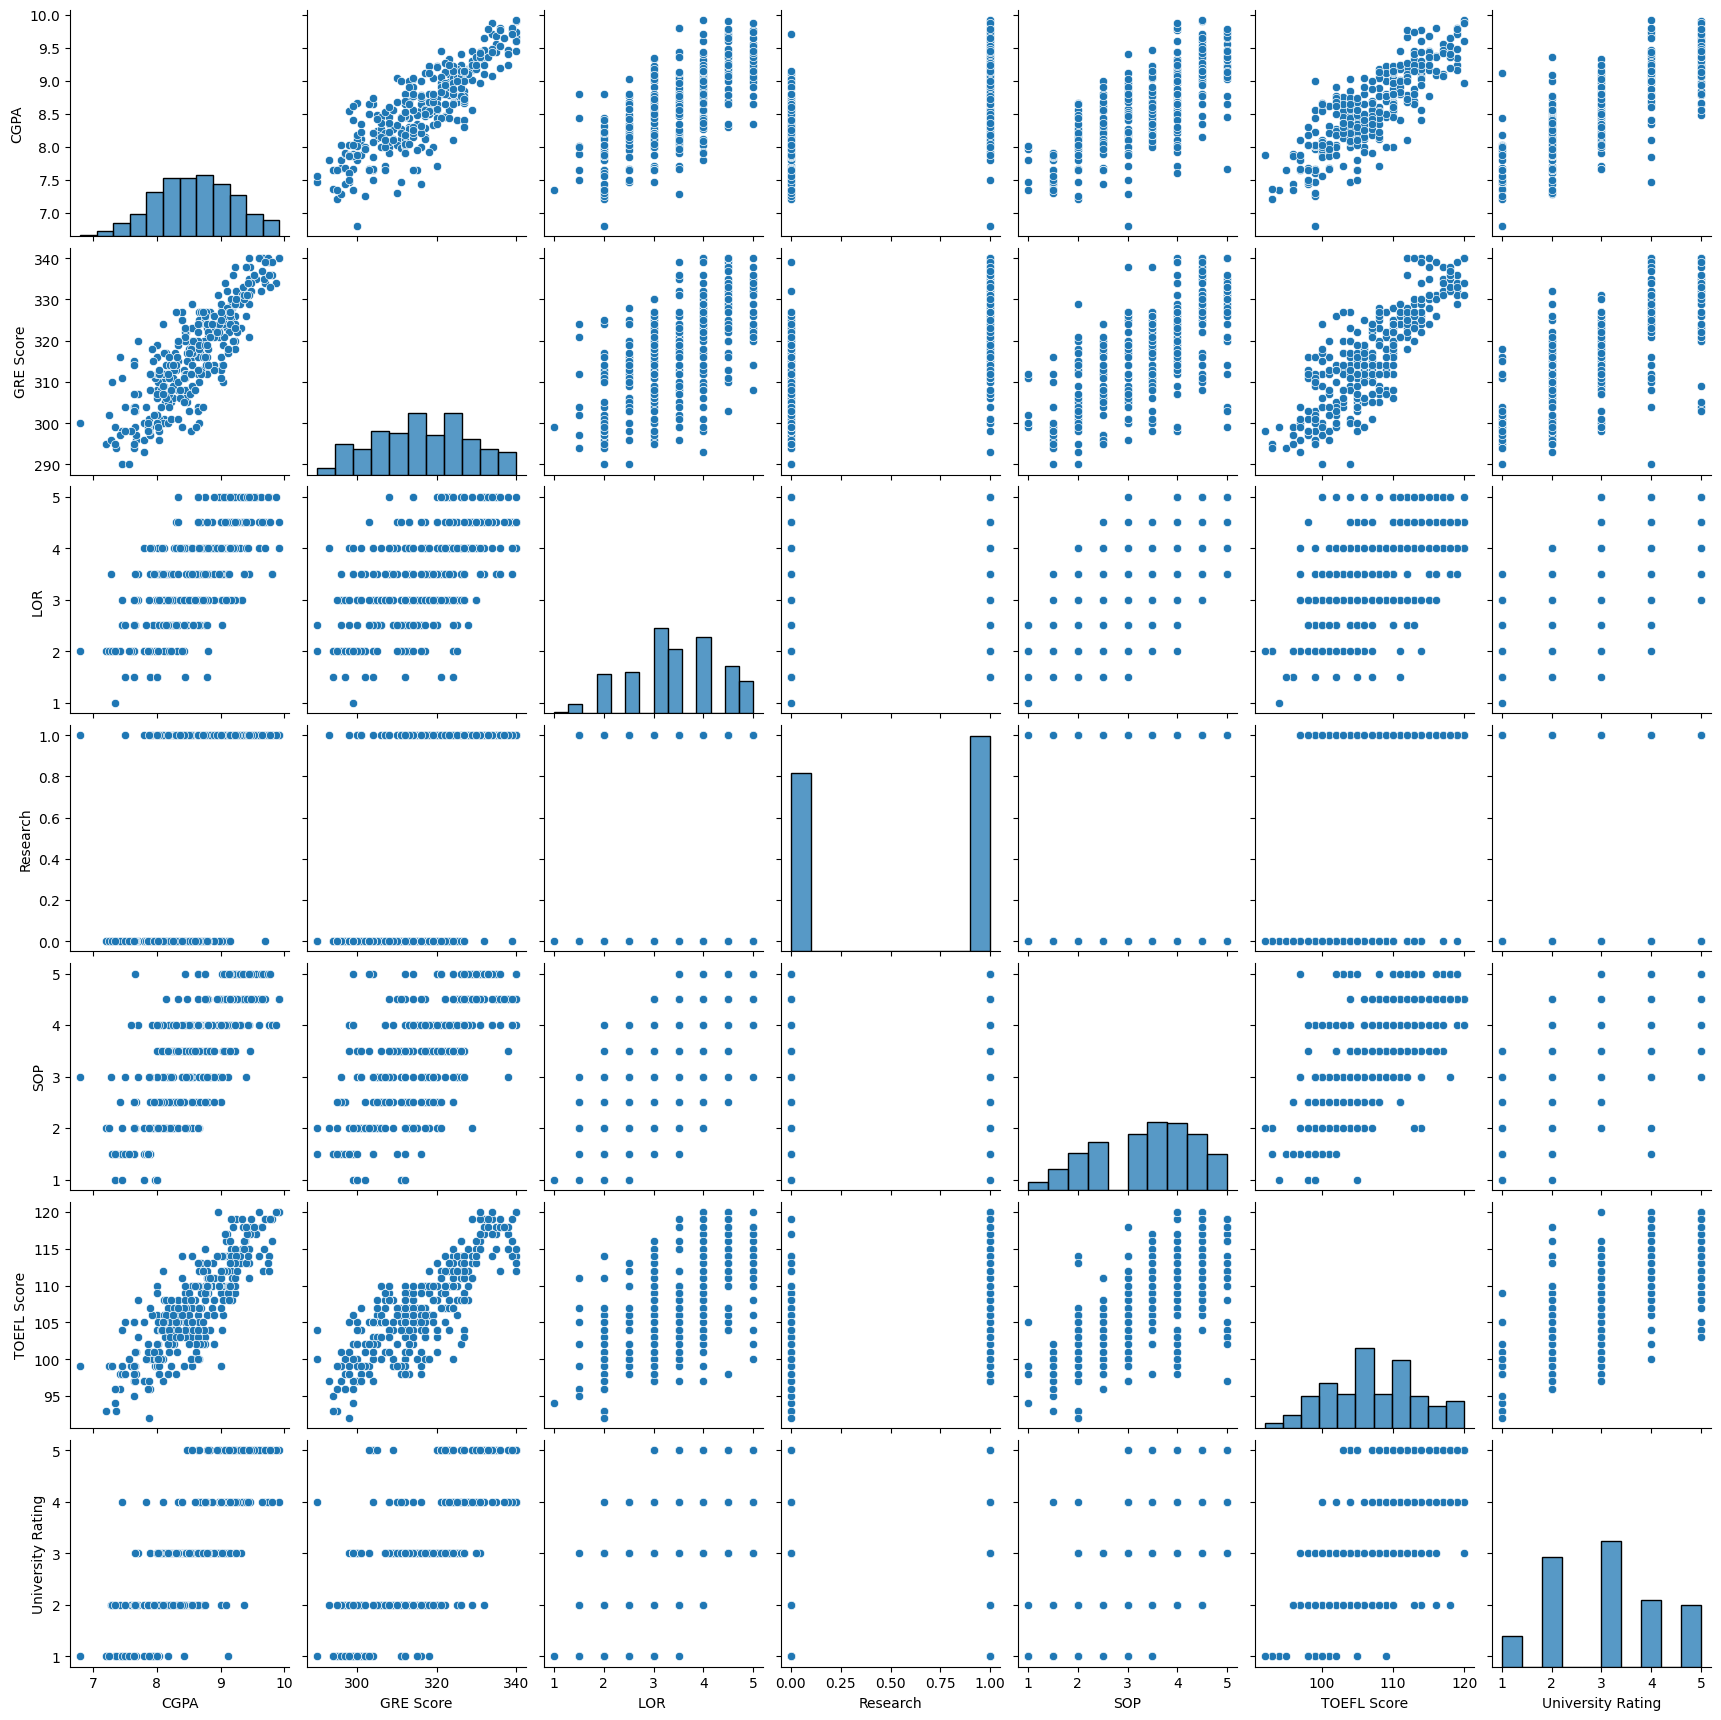

In [105]:
sns.pairplot(data_train[X.columns])

# (b) Model Initialization:
#### Initialize 3 different SVM models with the following kernels: *Linear, RBF, Polynomial(3)*

In [106]:
tuned_parameters = [{'C': [0.001, 0.01, 0.1, 1, 5, 10, 100], 'kernel':['linear','rbf','poly']}]
clf = GridSearchCV(SVC(degree=3), tuned_parameters, scoring='accuracy', return_train_score=True)
clf.fit(X,y)
clf.cv_results_

{'mean_fit_time': array([0.00523591, 0.0041153 , 0.00345407, 0.00284867, 0.0038641 ,
        0.00378022, 0.00320029, 0.00398765, 0.0026403 , 0.00305076,
        0.00411053, 0.0030396 , 0.00552649, 0.00444956, 0.0072485 ,
        0.00808306, 0.00823665, 0.01083384, 0.03279581, 0.00428824,
        0.03254375]),
 'std_fit_time': array([0.00199051, 0.00134566, 0.00114984, 0.00071325, 0.00073191,
        0.00075775, 0.0014779 , 0.00089071, 0.00076771, 0.00097584,
        0.00170546, 0.00052312, 0.00190619, 0.00152157, 0.00161135,
        0.0014917 , 0.00189632, 0.00245481, 0.01167221, 0.00081294,
        0.01590051]),
 'mean_score_time': array([0.0031951 , 0.00279064, 0.00223007, 0.00240455, 0.00368547,
        0.00239558, 0.00198317, 0.00299177, 0.00219684, 0.00223894,
        0.00308814, 0.0025804 , 0.00159402, 0.00339561, 0.00259833,
        0.00531354, 0.00377913, 0.00448055, 0.00207167, 0.00238762,
        0.00247736]),
 'std_score_time': array([7.53269069e-04, 4.04631026e-04, 6.931006

In [107]:
clf.best_params_, float(clf.best_score_)

({'C': 100, 'kernel': 'rbf'}, 0.8047511312217195)

Instead of 'initializing' I made a gridsearch similar to the one in the lab shown in class. This trains a model on the different combinations of the 3 kernels as well as different slack amounts. On the training dataset the highest accuracy was found using C=1 and a linear kernel.

In the next section I will select the features passed into the gridsearch.

# (c) Feature Selection and Model Training:
#### Train each SVM Model above with the following feature combinations to predict admission.
> #### 1. CGPA and SOP
> #### 2. CGPA and GRE Score
> #### 3. SOP and LOR
> #### 4. LOR and GRE Score

In [134]:
params = [{'C': [1, 3, 5, 10, 25, 50, 75, 100], 'kernel':['linear','rbf','poly']}]
clf = GridSearchCV(SVC(degree=3), params, scoring='accuracy', return_train_score=True)
features = [['CGPA','SOP'],['CGPA','GRE Score'],['SOP','LOR '],['LOR ','GRE Score']]

D = dict()
for feat in features:
    clf.fit(X[feat],y)
    print(f'{feat}:\t{clf.best_params_}\t{float(clf.best_score_)}')
    D[feat[0]+','+feat[1]]={'params':clf.best_params_,'sv':clf.best_estimator_.support_vectors_}

['CGPA', 'SOP']:	{'C': 3, 'kernel': 'rbf'}	0.7539969834087481


c:\Users\nick2\AppData\Local\Programs\Python\Python312\Lib\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


['CGPA', 'GRE Score']:	{'C': 75, 'kernel': 'rbf'}	0.7619155354449472
['SOP', 'LOR ']:	{'C': 50, 'kernel': 'rbf'}	0.7348416289592761
['LOR ', 'GRE Score']:	{'C': 3, 'kernel': 'rbf'}	0.7584464555052791


# (d) Support Vectors:
#### What are the support vectors for each model and feature combination? How many support vectors does each class have in each case?

In [135]:
for k in D.keys():
    print(f'{k}\t{D[k]['sv']}')
for i,k in enumerate(D.keys()):
    print(f'{k}:{len(D[k]['sv'])}',end=',  ')

CGPA,SOP	[[ 1.66190286e+00  7.84740241e-01]
 [ 3.81403279e+00  2.35445699e+00]
 [ 1.60263710e+00  1.70144132e+00]
 [ 2.37783762e+00  1.43996884e+00]
 [ 1.25624129e+00  1.68246196e+00]
 [ 3.22824271e-01  3.51460217e-01]
 [ 2.03372556e+00  1.42954056e+00]
 [ 5.39699347e-01  5.55387473e-01]
 [ 2.12017130e+00  2.09021868e+00]
 [ 1.34730541e+00  9.02401781e-01]
 [ 1.88559782e+00  8.93085198e-01]
 [ 3.45716466e-01  6.85562670e-01]
 [ 1.13767533e+00  8.77556018e-01]
 [ 1.20047739e+00  5.86821724e-01]
 [ 1.13501786e+00  2.17544248e+00]
 [ 5.59295539e-01  1.76382032e-01]
 [-1.78411062e-01 -1.06567132e+00]
 [ 7.16691388e-01  3.02133528e-01]
 [ 1.47165051e+00  1.61537892e+00]
 [ 7.24691612e-01  3.58880155e-01]
 [ 2.40121353e-01  1.47191255e-02]
 [ 6.57520125e-01  4.38743554e-01]
 [ 6.74716585e-01  6.25559090e-01]
 [ 1.80256818e+00  1.64175674e+00]
 [ 4.01347884e-01  3.09456098e-01]
 [ 6.09218086e-01  6.75241602e-01]
 [ 1.57314613e+00  1.07816749e+00]
 [-2.48580258e-02  6.38699951e-01]
 [ 1.161597

# (e) Result Visualization:
#### For each kernel - input combination, visualize the predictions on the training set. Color code the points by their labels.

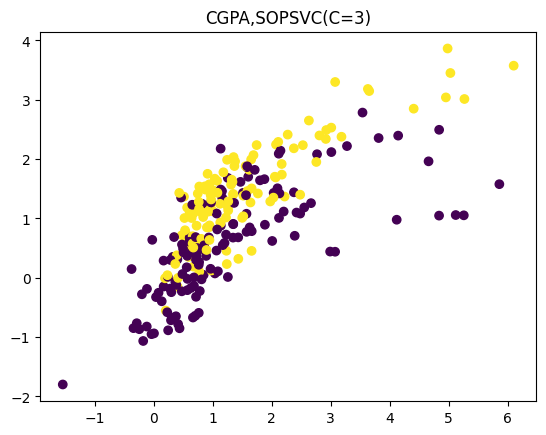

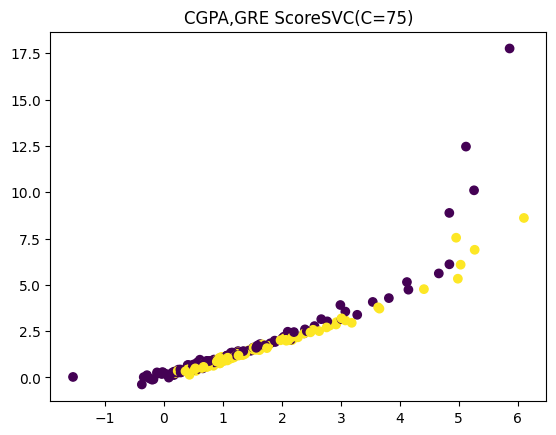

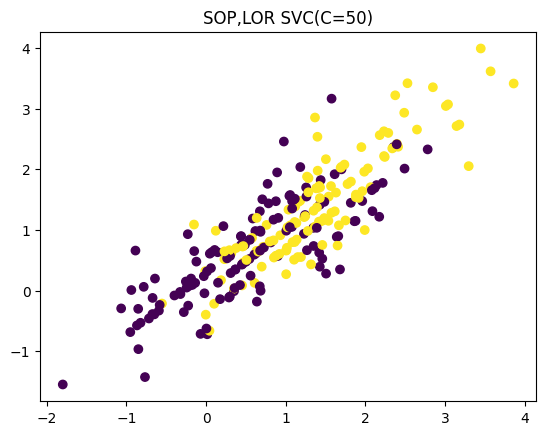

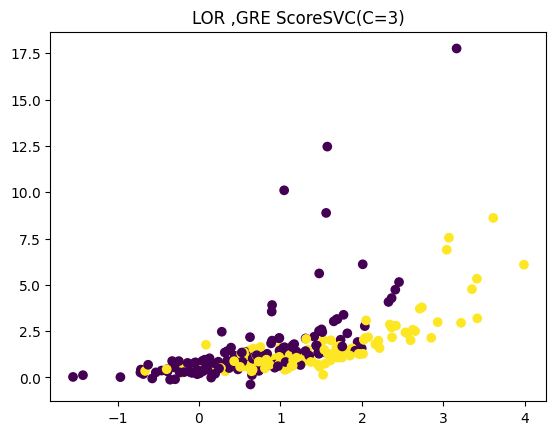

In [138]:
def plot(X, y, title): # basic plot f from wk9
    fig, ax  = plt.subplots()
    ax.scatter(X[:,0], X[:,1], c = y)
    ax.set_title(title)
    plt.show()

for k in D.keys():
    svc = SVC(C=D[k]['params']['C'], kernel=D[k]['params']['kernel'])
    svc.fit(np.array(X[k.split(',')]),np.array(y))
    plot(np.array(X[k.split(',')]),np.array(y),k+str(svc))

# (f) Result Analysis:
#### Just by looking at the figures you generated, answer this question:
##### Which features + kernel combinations give you the best result? Validate your model on the validation set and find the best performing combination with respect to accuracy.

CGPA + GRE Score | C=75 | rbf kernel, the predictions look separable by a curved line which makes me think it does a better job using the two features to predict than the others.

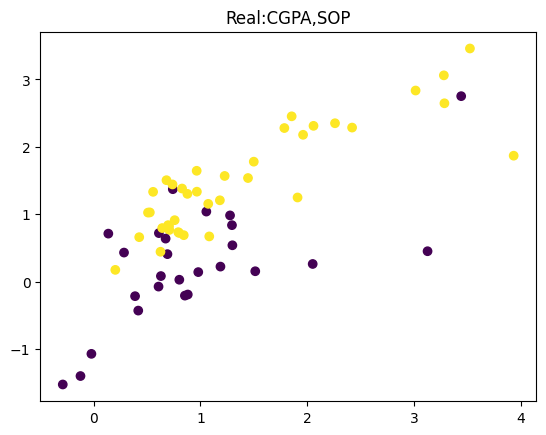

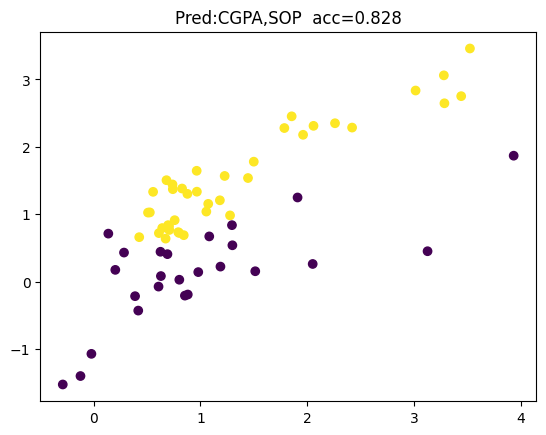

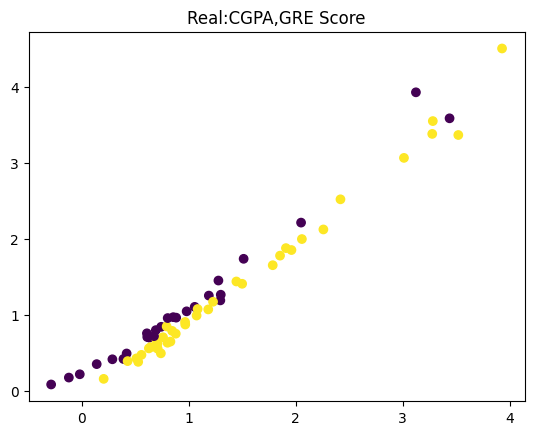

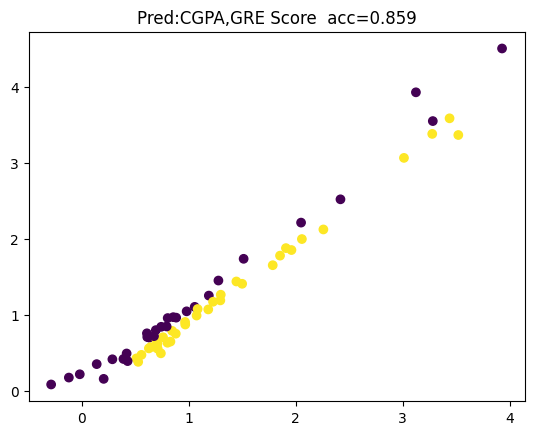

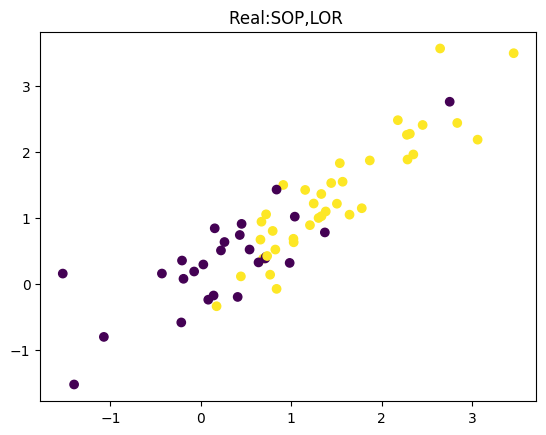

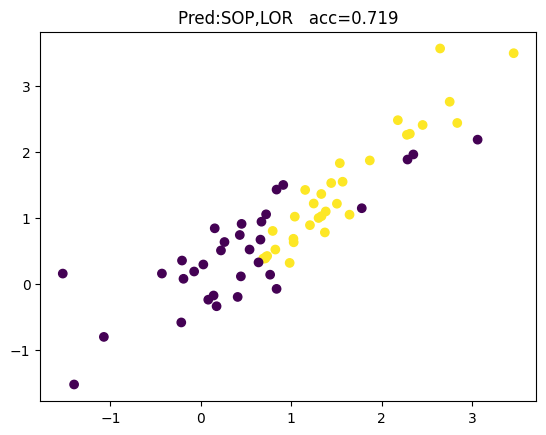

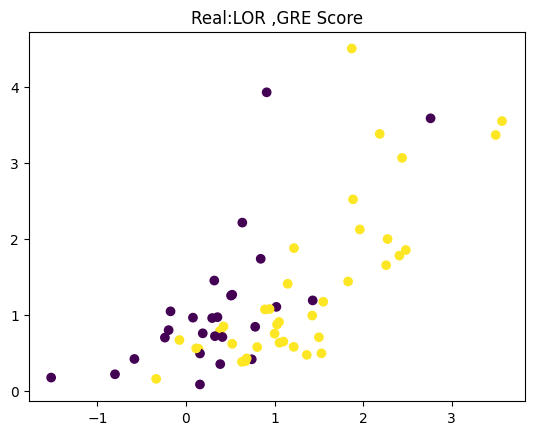

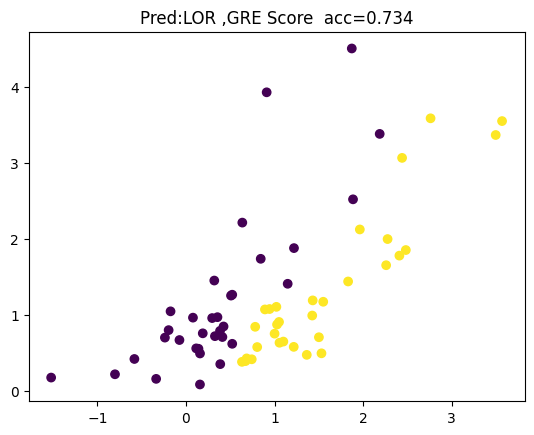

In [152]:
from sklearn.metrics import accuracy_score

sop_D = dict()
for i,k in enumerate(D.keys()):
    svc = SVC(C=D[k]['params']['C'], kernel=D[k]['params']['kernel'])
    svc.fit(np.array(X[k.split(',')]),np.array(y))

    pred = svc.predict(np.array(Xv[k.split(',')]))

    plot(np.array(Xv[k.split(',')]),np.array(yv),'Real:'+k)
    plot(np.array(Xv[k.split(',')]),np.array(pred),'Pred:'+k+'  acc='+str(round(accuracy_score(yv,pred),3)))

This ends up being true, though SOP was also a pretty good feature and may be able to help the model.

In [149]:
i = features[1]+['SOP']
params = [{'C': [0.1, 1, 3, 5, 10, 25, 50, 75, 100], 'kernel':['linear','rbf','poly']}]
clf = GridSearchCV(SVC(degree=3), params, scoring='accuracy', return_train_score=True)

clf.fit(X[i],y)
print(f'{i}:\t{clf.best_params_}\t{float(clf.best_score_)}')

['CGPA', 'GRE Score', 'SOP']:	{'C': 50, 'kernel': 'rbf'}	0.7893665158371039


SOP did best with low slack, GRE with high. Maybe with more testing the two models can vote and become a little more accurate.

# (g) Inference:
#### Use the best model you found in the previous step to predict the label of the test data. Save the prediction in a csv file ”FirstName LastName preds.csv”

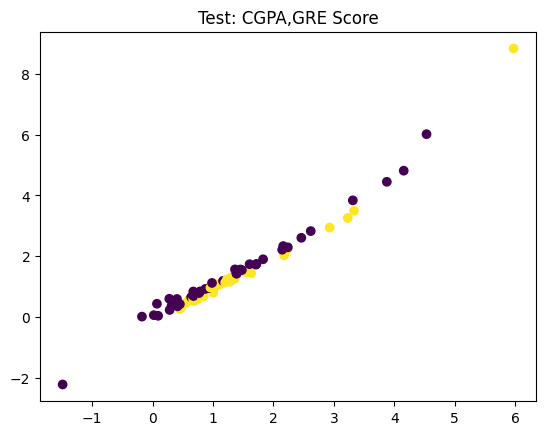

In [154]:
k = list(D.keys())[1]
svc = SVC(C=D[k]['params']['C'], kernel=D[k]['params']['kernel'])
svc.fit(np.array(X[k.split(',')]),np.array(y))

pred = svc.predict(np.array(test[k.split(',')]))

plot(np.array(test[k.split(',')]),np.array(pred),'Test: '+k)

In [158]:
pd.Series(pred,name='preds').to_csv('Nicholas Garde_preds.csv',index=False)

In [166]:
### /// ### /// ###
###   Scratch   ###
# X[k.split(',')].reset_index(drop=True)
# np.array(X).dtype,np.array(y).dtype
# df = data_train.copy(deep=True)
# med = df['Chance of Admit '].median()
# label = pd.Series(df['Chance of Admit '].map(lambda x:1 if x>med else 0),name='binary label')
# pd.concat([df,label],axis=1)
# df
### /// ### /// ### σ

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,109.0,331.0,116.0,5.0,5.0,5.0,9.38,1.0,0.93
1,346.0,316.0,98.0,1.0,1.5,2.0,7.43,0.0,0.49
2,99.0,332.0,119.0,4.0,5.0,4.5,9.24,1.0,0.90
3,210.0,301.0,104.0,3.0,3.5,4.0,8.12,1.0,0.68
4,242.0,317.0,103.0,2.0,2.5,2.0,8.15,0.0,0.65
...,...,...,...,...,...,...,...,...,...
315,1.0,337.0,118.0,4.0,4.5,4.5,9.65,1.0,0.92
316,376.0,304.0,101.0,2.0,2.0,2.5,7.66,0.0,0.38
317,327.0,299.0,100.0,3.0,2.0,2.0,8.02,0.0,0.63
318,379.0,303.0,98.0,1.0,2.0,2.5,7.65,0.0,0.56
